In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import warnings
import prophet
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
warnings.filterwarnings("ignore")
# import keras

In [5]:
data = pd.read_csv('../data/regional_multivariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/multivariate/enc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
esc = pd.read_csv('../data/regional_datasets/multivariate/esc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
midatl = pd.read_csv('../data/regional_datasets/multivariate/mid_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
mount = pd.read_csv('../data/regional_datasets/multivariate/mountain_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
ne = pd.read_csv('../data/regional_datasets/multivariate/new_england_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
pac = pd.read_csv('../data/regional_datasets/multivariate/pacific_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
satl = pd.read_csv('../data/regional_datasets/multivariate/south_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wnc = pd.read_csv('../data/regional_datasets/multivariate/wnc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wsc = pd.read_csv('../data/regional_datasets/multivariate/wsc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(actual,forecast): 
    actual, forecast = np.array(actual), np.array(forecast)
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

In [7]:
def process(df):
    x = df.drop(columns = ['new_confirmed', 'region'] + [col for col in df.columns if col[0].isdigit()])
    lag1df = x.shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df = df[['new_confirmed'] + [col for col in df.columns if col[0].isdigit()]].join(lag1df)
    return df.fillna(0)

In [8]:
enc1 = process(enc)
model = prophet.Prophet()
for col in enc1.columns:
    if col not in ['date', 'new_confirmed']:
        model.add_regressor(col)
model=model.fit(enc1.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))

13:47:51 - cmdstanpy - INFO - Chain [1] start processing
13:47:51 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
enc1.columns[(abs(enc1.corr().new_confirmed) > 0.5)].drop('new_confirmed')

Index(['1_day_shift', '7_day_avg', '2_day_shift', '7_day_shift',
       'lag1_new_hospitalized_patients', 'lag1_current_hospitalized_patients'],
      dtype='object')

In [10]:
train_pred=model.predict(enc1.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})).set_index('ds')
train_pred

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,1_day_shift,1_day_shift_lower,1_day_shift_upper,2_day_shift,2_day_shift_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2020-03-05,-59063.638233,-8922.167407,12199.968037,-59063.638233,-59063.638233,1092.889301,1092.889301,1092.889301,1664.144094,1664.144094,...,1087.375317,1087.375317,1087.375317,7458.239938,7458.239938,7458.239938,0.0,0.0,0.0,1469.704576
2020-03-06,-58893.846821,-11601.373827,10657.865699,-58893.846821,-58893.846821,1090.862253,1090.862253,1090.862253,1664.144094,1664.144094,...,1794.423947,1794.423947,1794.423947,7172.992972,7172.992972,7172.992972,0.0,0.0,0.0,-682.395722
2020-03-07,-58724.055409,-14537.399809,6406.009249,-58724.055409,-58724.055409,1089.811191,1089.811191,1089.811191,1661.049661,1661.049661,...,-1551.938169,-1551.938169,-1551.938169,6943.465856,6943.465856,6943.465856,0.0,0.0,0.0,-4484.988333
2020-03-08,-58554.263997,-19482.546745,1898.040087,-58554.263997,-58554.263997,1089.210585,1089.210585,1089.210585,1659.445139,1659.445139,...,-3449.532899,-3449.532899,-3449.532899,6772.158912,6772.158912,6772.158912,0.0,0.0,0.0,-8823.003381
2020-03-09,-58384.472585,-9458.924595,11805.092990,-58384.472585,-58384.472585,1088.084447,1088.084447,1088.084447,1658.528270,1658.528270,...,520.500383,520.500383,520.500383,6659.621226,6659.621226,6659.621226,0.0,0.0,0.0,1554.385949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-11,86617.404555,-1388.782442,19386.196351,86617.404555,86617.404555,1081.928228,1081.928228,1081.928228,1664.144094,1664.144094,...,520.500383,520.500383,520.500383,-2611.571155,-2611.571155,-2611.571155,0.0,0.0,0.0,9046.547214
2022-07-12,86787.195992,9248.138236,31434.311459,86787.195992,86787.195992,-366.660148,-366.660148,-366.660148,1647.411231,1647.411231,...,-905.026568,-905.026568,-905.026568,-2729.553907,-2729.553907,-2729.553907,0.0,0.0,0.0,20640.399756
2022-07-13,86956.987429,10093.231441,31855.420816,86956.987429,86956.987429,-231.673784,-231.673784,-231.673784,-563.962762,-563.962762,...,2504.197988,2504.197988,2504.197988,-2855.043300,-2855.043300,-2855.043300,0.0,0.0,0.0,21317.964129


In [11]:
enc1.rename(columns = {'new_confirmed': 'yhat'}).reset_index()

,date,yhat,1_day_shift,7_day_avg,2_day_shift,7_day_shift,lag1_new_deceased,lag1_cumulative_confirmed,lag1_cumulative_deceased,lag1_new_hospitalized_patients,...,lag1_income_support,lag1_debt_relief,lag1_public_information_campaigns,lag1_testing_policy,lag1_contact_tracing,lag1_facial_coverings,lag1_vaccination_policy,lag1_stringency_index,lag1_minimum_temperature_celsius,lag1_maximum_temperature_celsius
0,2020-03-05,27.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000
1,2020-03-06,41.0,27.0,0.000000,0.0,0.0,0.0,106.0,1.0,0.0,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-7.461111,14.244444
2,2020-03-07,49.0,41.0,0.000000,27.0,0.0,0.0,147.0,1.0,0.0,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-5.494444,12.827778
3,2020-03-08,64.0,49.0,0.000000,41.0,0.0,0.0,196.0,1.0,0.0,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-11.422222,12.222222
4,2020-03-09,125.0,64.0,0.000000,49.0,0.0,0.0,260.0,1.0,0.0,...,0.0,0.0,1.2,1.0,1.0,0.0,0.0,17.778,-2.700000,18.938889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,2022-07-11,19441.0,146.0,14254.142857,0.0,0.0,0.0,12481195.0,153297.0,590.0,...,0.6,1.0,2.0,3.0,1.8,1.4,5.0,30.186,8.544444,30.117284
859,2022-07-12,17643.0,19441.0,13736.142857,146.0,21269.0,64.0,12500636.0,153361.0,647.0,...,0.6,1.0,2.0,3.0,1.8,1.4,5.0,30.186,14.166667,31.654321
860,2022-07-13,18425.0,17643.0,13499.428571,19441.0,20082.0,148.0,12518279.0,153509.0,772.0,...,0.6,1.0,2.0,3.0,1.8,1.4,5.0,30.186,15.679012,30.511111
861,2022-07-14,31850.0,18425.0,14249.571429,17643.0,26599.0,71.0,12536704.0,153580.0,784.0,...,0.6,1.0,2.0,3.0,1.8,1.4,5.0,30.186,14.616667,31.211111


In [12]:
pd.concat([enc1.rename(columns = {'new_confirmed': 'yhat'}).reset_index().yhat,train_pred.reset_index().yhat], axis=1)

,yhat,yhat
0,27.0,1469.704576
1,41.0,-682.395722
2,49.0,-4484.988333
3,64.0,-8823.003381
4,125.0,1554.385949
...,...,...
858,19441.0,9046.547214
859,17643.0,20640.399756
860,18425.0,21317.964129
861,31850.0,24391.796327


<Axes: >

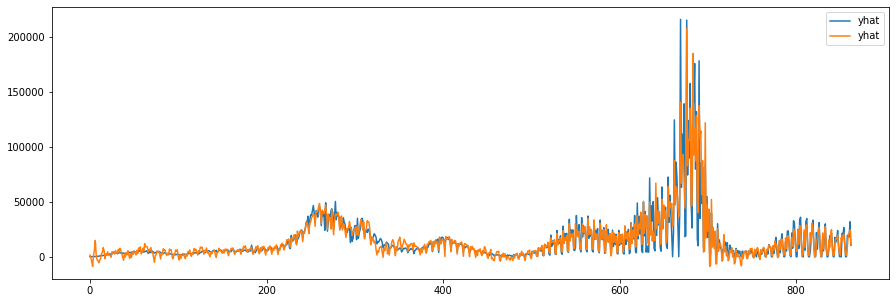

In [13]:
pd.concat([enc1.rename(columns = {'new_confirmed': 'yhat'}).reset_index().yhat,train_pred.reset_index().yhat], axis=1).plot(figsize=(15,5)) 

In [14]:
data

,region,date,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,...,income_support,debt_relief,public_information_campaigns,testing_policy,contact_tracing,facial_coverings,vaccination_policy,stringency_index,minimum_temperature_celsius,maximum_temperature_celsius
0,East North Central,2020-03-05,27.0,0.0,106.0,1.0,0.0,189608.3,4693.1,1599.6,...,0.00,0.00,1.2,1.0,1.00,0.0,0.0,17.778,-7.461111,14.244444
1,East North Central,2020-03-06,41.0,0.0,147.0,1.0,0.0,196886.2,4728.6,1599.9,...,0.00,0.00,1.2,1.0,1.00,0.0,0.0,17.778,-5.494444,12.827778
2,East North Central,2020-03-07,49.0,0.0,196.0,1.0,0.0,204746.4,4743.5,1607.7,...,0.00,0.00,1.2,1.0,1.00,0.0,0.0,17.778,-11.422222,12.222222
3,East North Central,2020-03-08,64.0,0.0,260.0,1.0,0.0,187631.5,4555.0,1464.7,...,0.00,0.00,1.2,1.0,1.00,0.0,0.0,17.778,-2.700000,18.938889
4,East North Central,2020-03-09,125.0,0.0,385.0,1.0,0.0,199875.4,4231.3,1208.1,...,0.00,0.00,1.2,1.0,1.00,0.0,0.0,17.778,1.861111,18.011111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7649,West South Central,2022-06-30,23453.0,34.0,10355924.0,132366.0,764.0,768539.0,3535.0,520.0,...,0.25,0.75,2.0,3.0,1.25,1.0,5.0,31.945,17.916667,36.173611
7650,West South Central,2022-07-01,16403.0,32.0,10372327.0,132398.0,728.0,769267.0,3611.0,516.0,...,0.25,0.75,2.0,3.0,1.25,1.0,5.0,31.945,22.194444,37.574074
7651,West South Central,2022-07-02,1403.0,4.0,10373730.0,132402.0,742.0,770009.0,3572.0,534.0,...,0.25,0.75,2.0,3.0,1.25,1.0,5.0,31.945,22.194444,37.697531
7652,West South Central,2022-07-03,165.0,0.0,10373895.0,132402.0,634.0,770643.0,3606.0,526.0,...,0.25,0.75,2.0,3.0,1.25,1.0,5.0,31.945,22.481481,36.938272


In [15]:
(abs(.drop(columns = 'ds').corr().y)).sort_values(ascending = False)

SyntaxError: invalid syntax (1893985522.py, line 1)

In [16]:
enc

,region,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,new_persons_vaccinated,...,contact_tracing,facial_coverings,vaccination_policy,stringency_index,minimum_temperature_celsius,maximum_temperature_celsius,1_day_shift,7_day_avg,2_day_shift,7_day_shift
date,,,,,,,,,,,,,,,,,,,,,
2020-03-05,East North Central,27.0,0.0,106.0,1.0,0.0,65586.95,3013.05,755.17,0.0,...,1.0,0.0,0.0,17.778,-7.461111,14.244444,NaN,NaN,NaN,NaN
2020-03-06,East North Central,41.0,0.0,147.0,1.0,0.0,63514.28,3106.85,784.39,0.0,...,1.0,0.0,0.0,17.778,-5.494444,12.827778,27.0,NaN,NaN,NaN
2020-03-07,East North Central,49.0,0.0,196.0,1.0,0.0,59644.23,3025.83,746.22,0.0,...,1.0,0.0,0.0,17.778,-11.422222,12.222222,41.0,NaN,27.0,NaN
2020-03-08,East North Central,64.0,0.0,260.0,1.0,0.0,68552.01,2667.92,667.38,0.0,...,1.0,0.0,0.0,17.778,-2.700000,18.938889,49.0,NaN,41.0,NaN
2020-03-09,East North Central,125.0,0.0,385.0,1.0,0.0,84213.22,2735.39,716.99,0.0,...,1.0,0.0,0.0,17.778,1.861111,18.011111,64.0,NaN,49.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-11,East North Central,19441.0,64.0,12500636.0,153361.0,647.0,761809.00,3971.00,448.00,0.0,...,1.8,1.4,5.0,30.186,14.166667,31.654321,146.0,14254.142857,0.0,0.0
2022-07-12,East North Central,17643.0,148.0,12518279.0,153509.0,772.0,762581.00,4046.00,461.00,0.0,...,1.8,1.4,5.0,30.186,15.679012,30.511111,19441.0,13736.142857,146.0,21269.0
2022-07-13,East North Central,18425.0,71.0,12536704.0,153580.0,784.0,763365.00,4154.00,481.00,0.0,...,1.8,1.4,5.0,30.186,14.616667,31.211111,17643.0,13499.428571,19441.0,20082.0


14:30:15 - cmdstanpy - INFO - Chain [1] start processing
14:30:15 - cmdstanpy - INFO - Chain [1] done processing


East North Central
0       4121.201571
1        399.108901
2       3037.832244
3      -3338.993327
4      -4348.080843
           ...     
124     5815.527767
125    16391.214875
126    17200.459871
127    20407.979094
128    11828.149151
Name: yhat, Length: 129, dtype: float64
MASE:  0.34923115948845


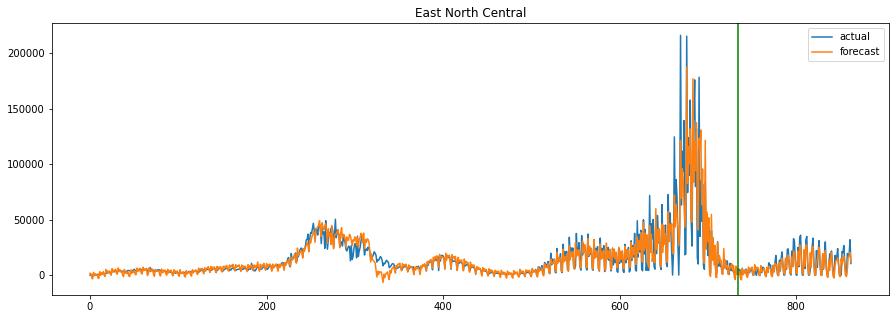

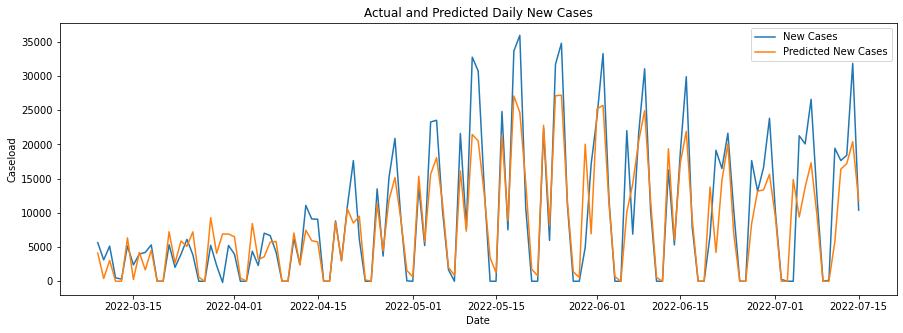

14:30:17 - cmdstanpy - INFO - Chain [1] start processing
14:30:17 - cmdstanpy - INFO - Chain [1] done processing


East South Central
0        -61.999804
1      -1349.542363
2       4439.701843
3       3548.498212
4       2123.869428
           ...     
124     3112.854602
125     2877.814376
126     1861.587869
127     1806.210772
128    12760.475943
Name: yhat, Length: 129, dtype: float64
MASE:  0.47099078792714477


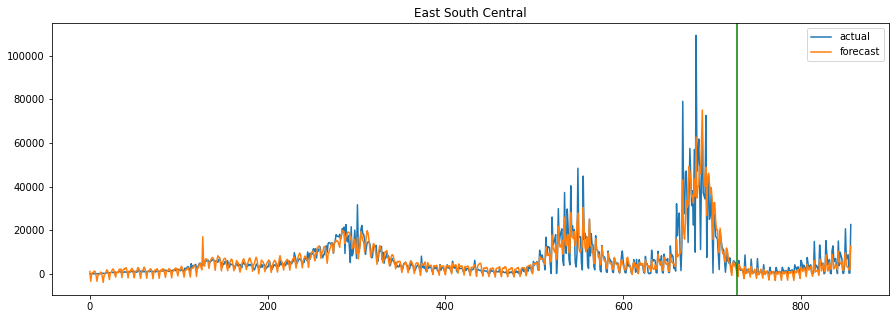

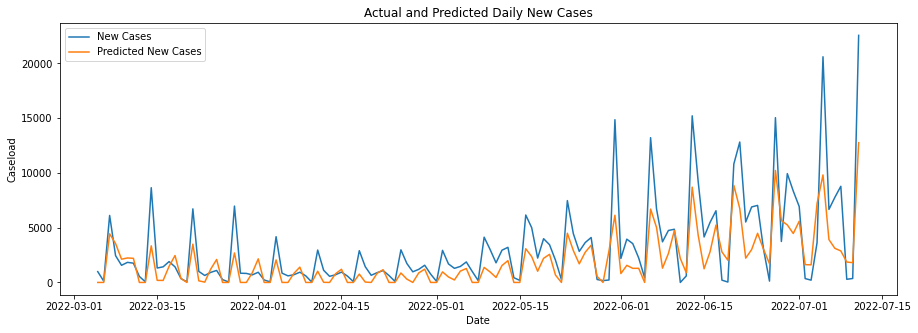

14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing


Mid-Atlantic
0       8066.415781
1       5269.648416
2       6713.643490
3       8559.790000
4       9413.678475
           ...     
122    12034.938223
123    14931.334289
124    12760.507450
125    14744.309154
126    13181.376904
Name: yhat, Length: 127, dtype: float64
MASE:  1.6584380619124484


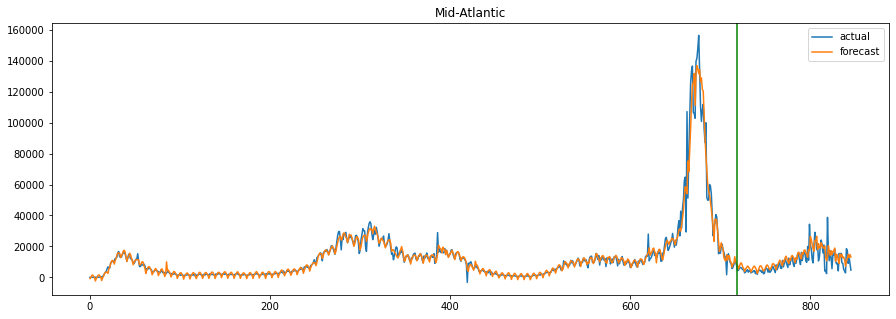

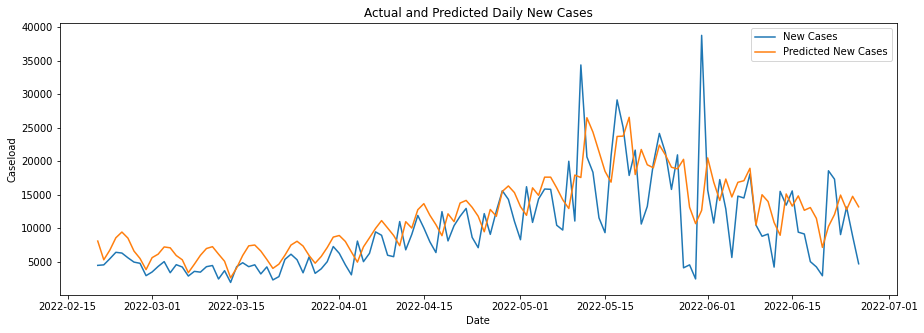

14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:20 - cmdstanpy - INFO - Chain [1] done processing


Mountain
0      6048.965571
1      5391.120574
2      6222.736487
3      1306.076372
4       128.521283
          ...     
123    2284.231732
124    8150.471476
125    4355.060139
126    3730.754865
127    -443.493872
Name: yhat, Length: 128, dtype: float64
MASE:  0.7879538782557446


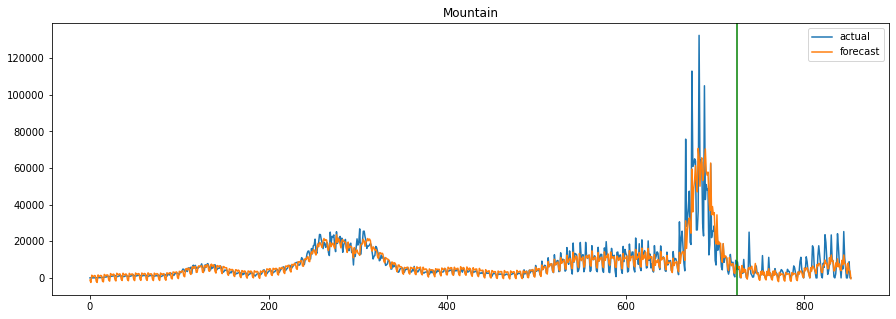

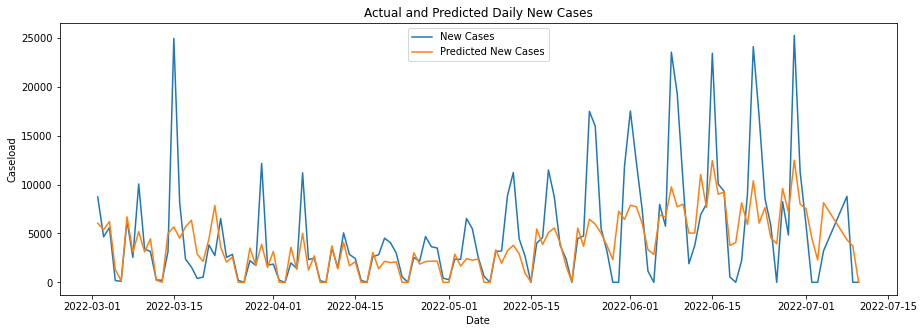

14:30:21 - cmdstanpy - INFO - Chain [1] start processing
14:30:21 - cmdstanpy - INFO - Chain [1] done processing


New England
0      1036.994021
1      4247.612914
2      4505.305781
3      3146.674402
4      2878.935934
          ...     
123    1779.937699
124    1756.999784
125   -1339.709659
126   -1838.267889
127    4142.827784
Name: yhat, Length: 128, dtype: float64
MASE:  0.5900625565942927


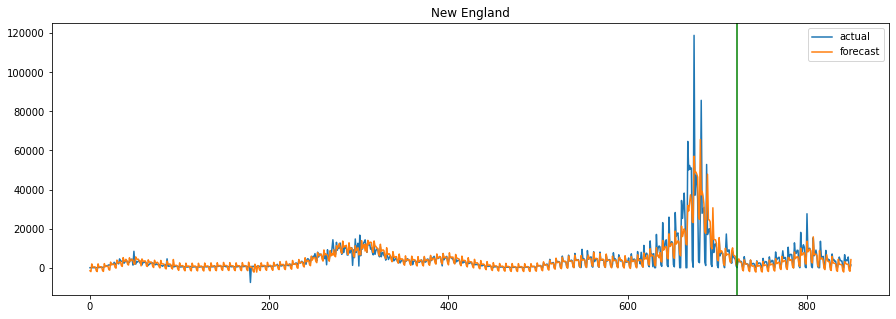

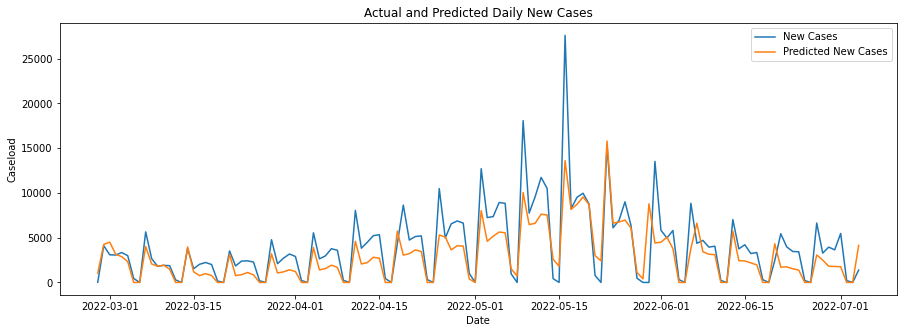

14:30:22 - cmdstanpy - INFO - Chain [1] start processing
14:30:22 - cmdstanpy - INFO - Chain [1] done processing


Pacific
0       5245.544932
1       2744.359186
2       5158.842259
3      -4616.597194
4      -5553.254729
           ...     
124     9438.306771
125    15755.322672
126    39531.708697
127    11067.251747
128    51726.438369
Name: yhat, Length: 129, dtype: float64
MASE:  1.0073203239200919


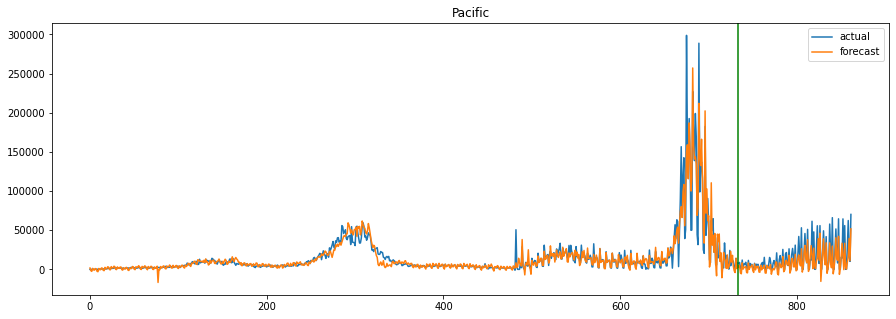

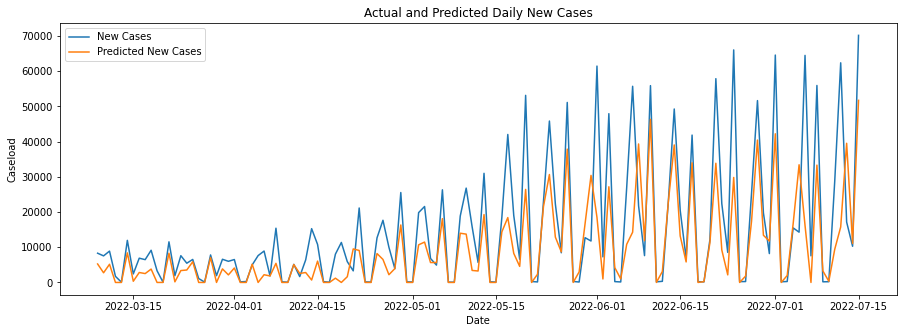

14:30:24 - cmdstanpy - INFO - Chain [1] start processing
14:30:24 - cmdstanpy - INFO - Chain [1] done processing


South Atlantic
0      16493.594548
1      15366.742106
2      10194.466498
3       9546.714027
4      -2592.273790
           ...     
122    12271.021672
123      991.096439
124    -3314.190818
125    19522.935962
126    25899.421495
Name: yhat, Length: 127, dtype: float64
MASE:  0.5745418264269029


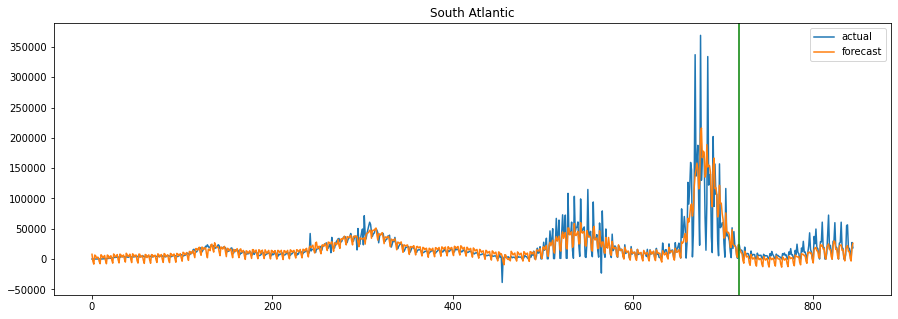

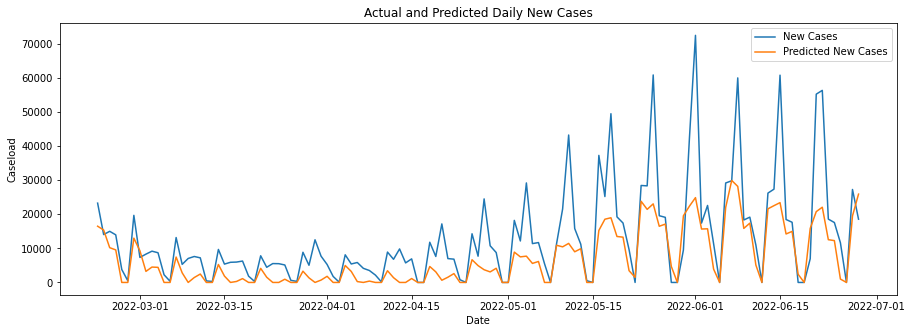

14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing


West North Central
0      18900.970022
1      10497.788652
2      11365.277133
3       3968.896051
4        287.512720
           ...     
119     5844.975702
120     2790.543866
121     4139.022538
122     -345.819297
123    -2826.275025
Name: yhat, Length: 124, dtype: float64
MASE:  0.5979453894218548


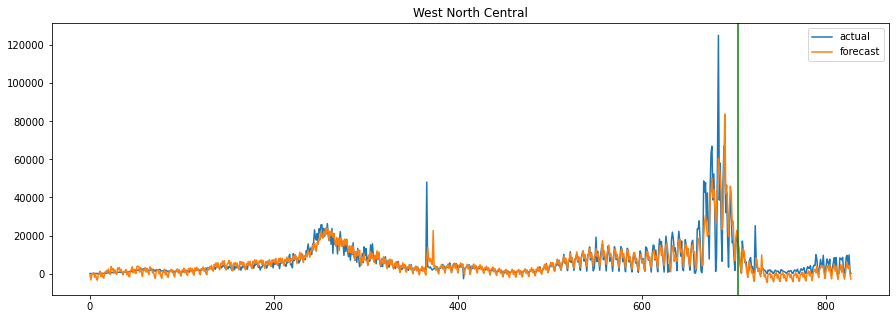

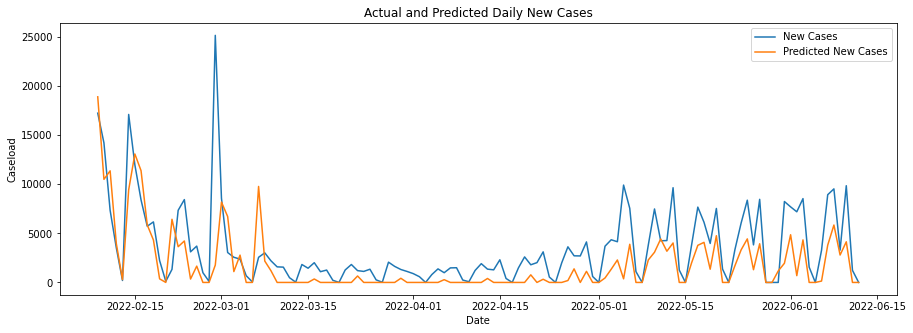

14:30:26 - cmdstanpy - INFO - Chain [1] start processing
14:30:26 - cmdstanpy - INFO - Chain [1] done processing


West South Central
0       -135.642464
1       6356.217155
2       6410.803669
3       5814.454659
4       5095.068923
           ...     
123    14380.904214
124    13763.165739
125     8143.391800
126     4573.044330
127     9328.753804
Name: yhat, Length: 128, dtype: float64
MASE:  0.5429606828232605


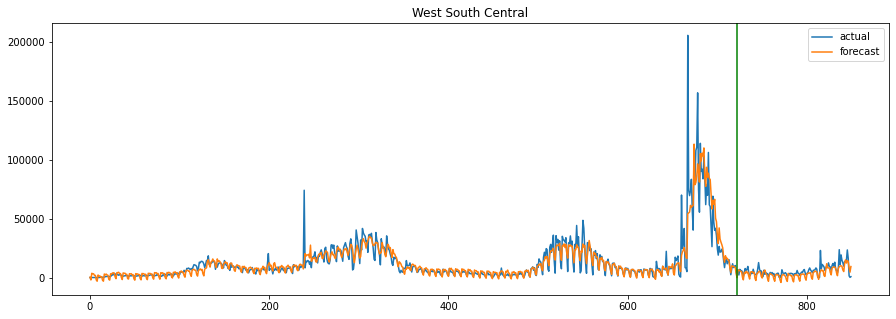

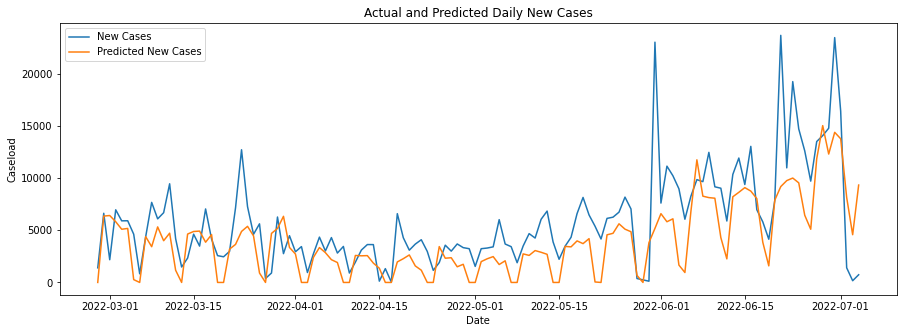

In [30]:
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    data = process(data1)
    # data = data1.drop(columns = ['region']).dropna()
    data = data.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
    size = round(data.shape[0]*0.15)
    train = data.iloc[:-size]
    test = data.iloc[-size:]
    model = prophet.Prophet()
    for col in train.drop(columns = 'ds').columns[(abs(train.drop(columns = 'ds').corr().y) > 0.6)].drop('y'):
        if col not in ['ds', 'y']:
            model.add_regressor(col)
    model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    train_pred = model.predict(train)
    test_pred = model.predict(test)
    pd.concat([pd.concat([train.reset_index().y,train_pred.reset_index().yhat], axis=1),
            pd.concat([test.reset_index().y,test_pred.reset_index().yhat], axis=1)],
            axis = 0).reset_index().drop(columns = 'index').plot(figsize=(15,5))
    plt.axvline(x = len(train), color = 'g')
    print(data1.region.unique()[0])

    print(test_pred['yhat'])
    test_pred = test_pred['yhat']

    for i in range(len(test_pred)):
        if test_pred[i] < 0:
            test_pred[i] = 0

    print("MASE: ", mean_absolute_scaled_error(test.y, test_pred, y_train = train.y))
    plt.legend(['actual', 'forecast'])
    plt.title(data1.region.unique()[0])

    test['ds'] = pd.to_datetime(test['ds'])
    plt.figure(figsize = (15, 5))
    plt.plot(test['ds'], test['y'], label='New Cases')
    plt.plot(test['ds'], test_pred, label='Predicted New Cases')
    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()


In [126]:
splitmases

[0.8594396152942281,
 0.8383680534919726,
 2.1439456131181203,
 3.288620624897965,
 3.3737826423372335]

In [103]:
best = dict()
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    mases = []
    print(data1.region.unique()[0])
    thresholds = np.linspace(0.5, 0.8, num = 10)
    for th in thresholds:
        data = process(data1)
        data = data.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
        size = round(data.shape[0]*0.2)
        train = data.iloc[:-size]
        test = data.iloc[-size:]
        model = prophet.Prophet()
        for col in train.drop(columns = 'ds').columns[(abs(train.drop(columns = 'ds').corr().y) > th)].drop('y'):
            if col not in ['ds', 'y']:
                model.add_regressor(col)
        model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
        train_pred = model.predict(train)
        test_pred = model.predict(test)
        mases.append(mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y))
        # plt.legend(['actual', 'forecast'])
        # plt.title(data1.region.unique()[0])
    print(np.min(mases))
    print(thresholds[np.argmin(mases)])
    best[data1.region.unique()[0]] = [np.min(mases), thresholds[np.argmin(mases)]]

22:48:20 - cmdstanpy - INFO - Chain [1] start processing
22:48:20 - cmdstanpy - INFO - Chain [1] done processing


East North Central


22:48:20 - cmdstanpy - INFO - Chain [1] start processing
22:48:20 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
22:48:22 - cmdstanpy - INFO - Chain [1] start processing
22:48:22 - cmdstanpy - INFO - Chain [1] done processing
22:48:22 - cmdstanpy - INFO - Chain [1] start processing
22:48:22 - cmdstanpy - INFO - Chain [1]

1.0181315590776145
0.7000000000000001
East South Central


22:48:22 - cmdstanpy - INFO - Chain [1] start processing
22:48:22 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] done processing
22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] done processing
22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1]

1.2552733926370128
0.6333333333333333
Mid-Atlantic


22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:24 - cmdstanpy - INFO - Chain [1] done processing
22:48:24 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing
22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing
22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1]

2.8037042530854115
0.5
Mountain


22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing
22:48:26 - cmdstanpy - INFO - Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:27 - cmdstanpy - INFO - Chain [1] start processing
22:48:27 - cmdstanpy - INFO - Chain [1] done processing
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1]

2.258636049623347
0.5
New England


22:48:28 - cmdstanpy - INFO - Chain [1] done processing
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] done processing
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] done processing
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
22:48:29 - cmdstanpy - INFO - Chain [1] 

2.313174126615097
0.6
Pacific


22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
22:48:30 - cmdstanpy - INFO - Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1] done processing
22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1] done processing
22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1] done processing
22:48:31 - cmdstanpy - INFO - Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1]

2.141604044153074
0.5666666666666667
South Atlantic


22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
22:48:33 - cmdstanpy - INFO - Chain [1] start processing
22:48:33 - cmdstanpy - INFO - Chain [1] done processing
22:48:33 - cmdstanpy - INFO - Chain [1] start processing
22:48:33 - cmdstanpy - INFO - Chain [1] done processing
22:48:33 - cmdstanpy - INFO - Chain [1] start processing
22:48:33 - cmdstanpy - INFO - Chain [1]

2.1884481243202467
0.8
West North Central


22:48:33 - cmdstanpy - INFO - Chain [1] start processing
22:48:33 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:34 - cmdstanpy - INFO - Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] done processing
22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1]

2.0288826669081663
0.7666666666666667
West South Central


22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] done processing
22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] done processing
22:48:35 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1] done processing
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
22:48:36 - cmdstanpy - INFO - Chain [1]

1.8830070055150367
0.8


16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:50:25 - cmdstanpy - INFO - Chain [1] done processing
16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:50:25 - cmdstanpy - INFO - Chain [1] done processing
16:50:26 - cmdstanpy - INFO - Chain [1] start processing
16:50:26 - cmdstanpy - INFO - Chain [1] done processing
16:50:26 - cmdstanpy - INFO - Chain [1] start processing
16:50:26 - cmdstanpy - INFO - Chain [1] done processing
16:50:26 - cmdstanpy - INFO - Chain [1] start processing
16:50:26 - cmdstanpy - INFO - Chain [1] done processing
16:50:26 - cmdstanpy - INFO - Chain [1] start processing
16:50:26 - cmdstanpy - INFO - Chain [1] done processing
16:50:27 - cmdstanpy - INFO - Chain [1] start processing
16:50:27 - cmdstanpy - INFO - Chain [1] done processing
16:50:27 - cmdstanpy - INFO - Chain [1] start processing
16:50:27 - cmdstanpy - INFO - Chain [1] done processing
16:50:27 - cmdstanpy - INFO - Chain [1] start processing
16:50:27 - cmdstanpy - INFO - Chain [1]

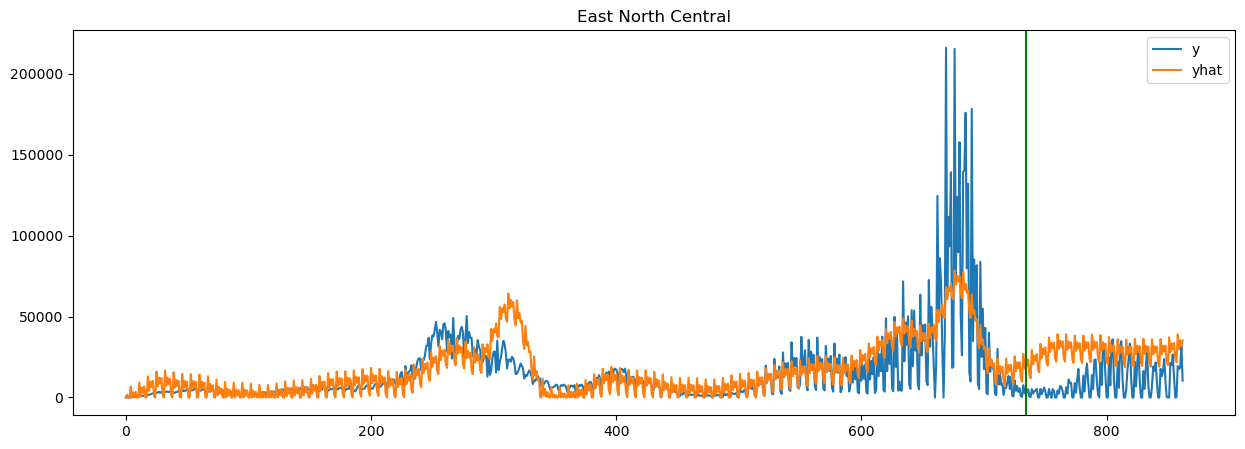

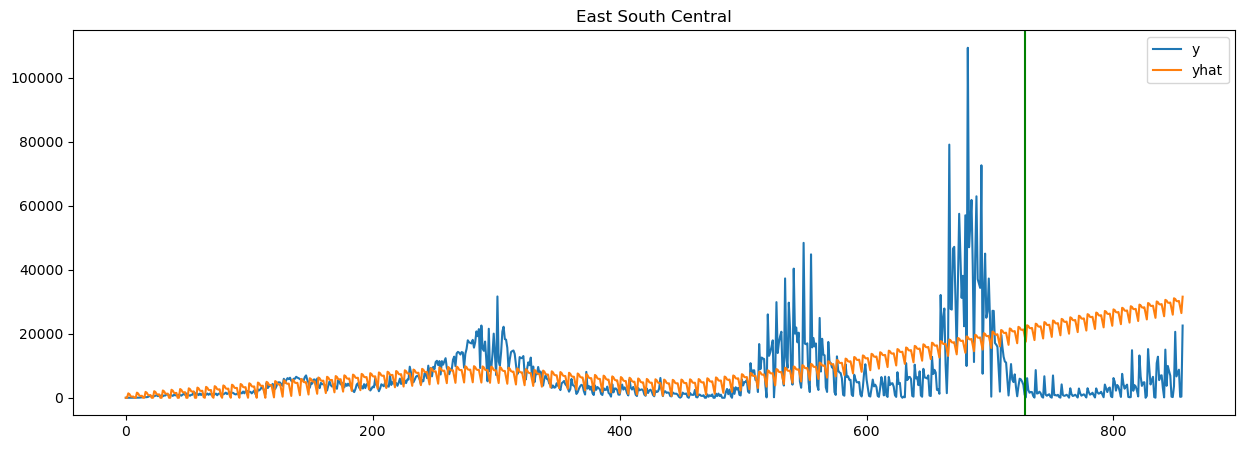

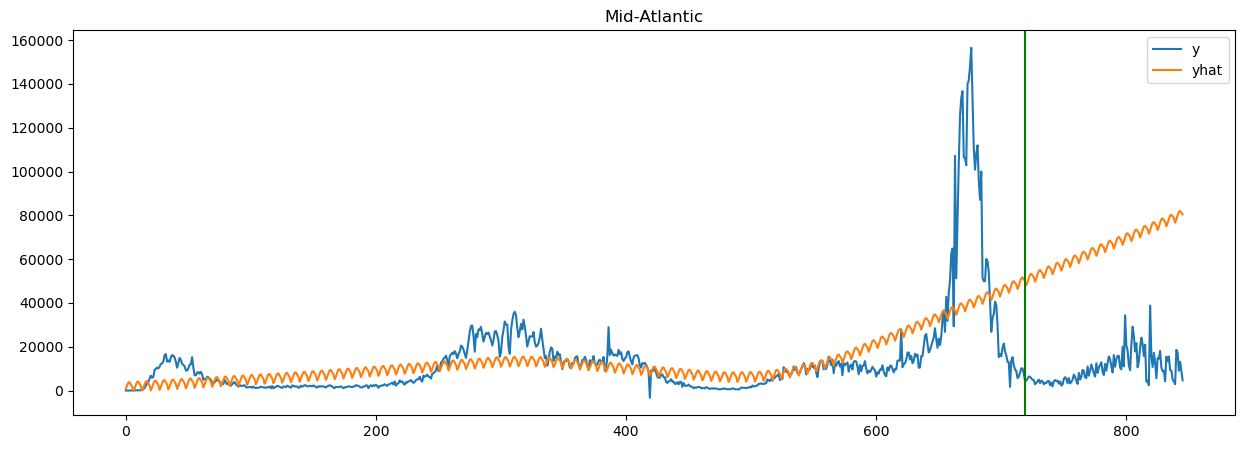

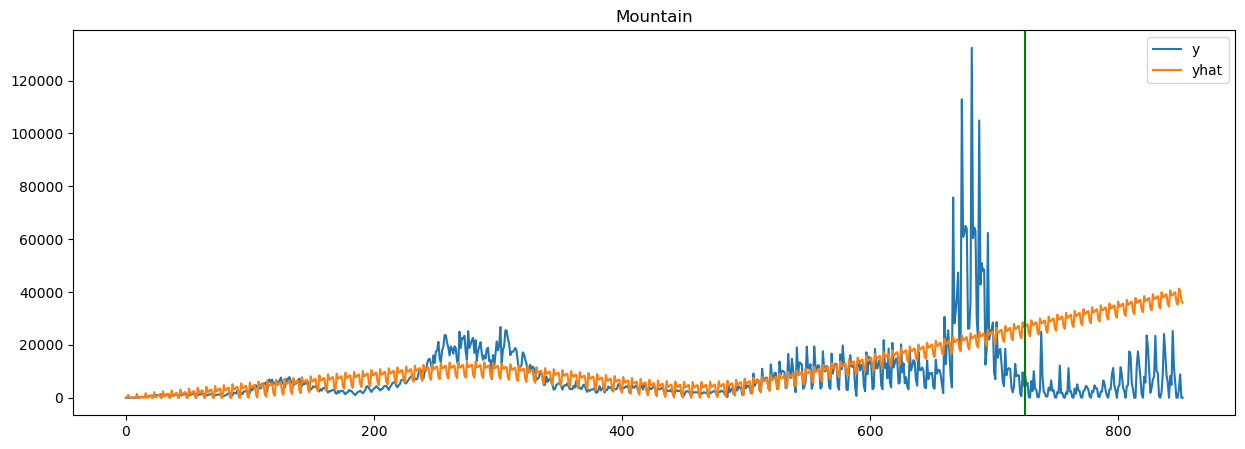

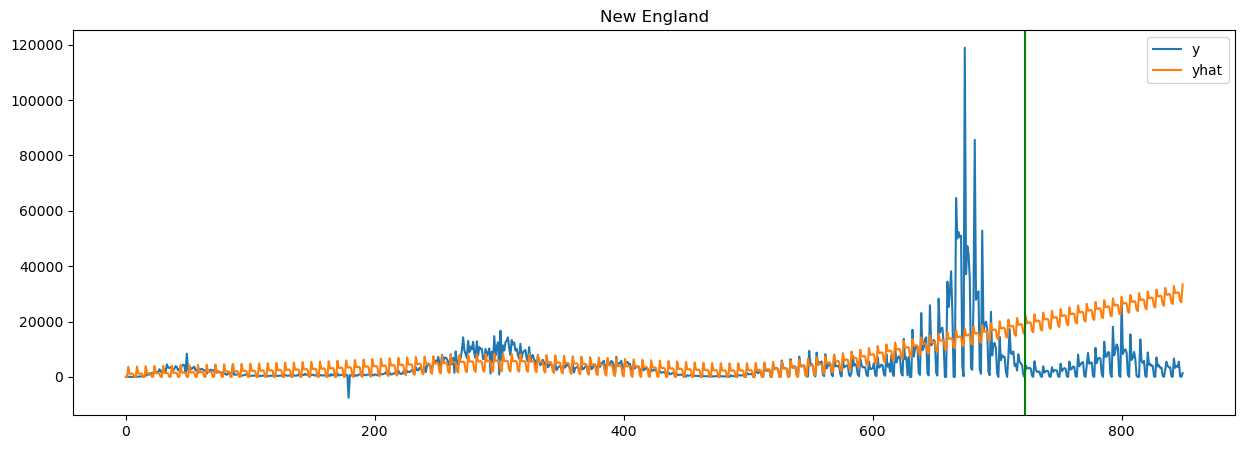

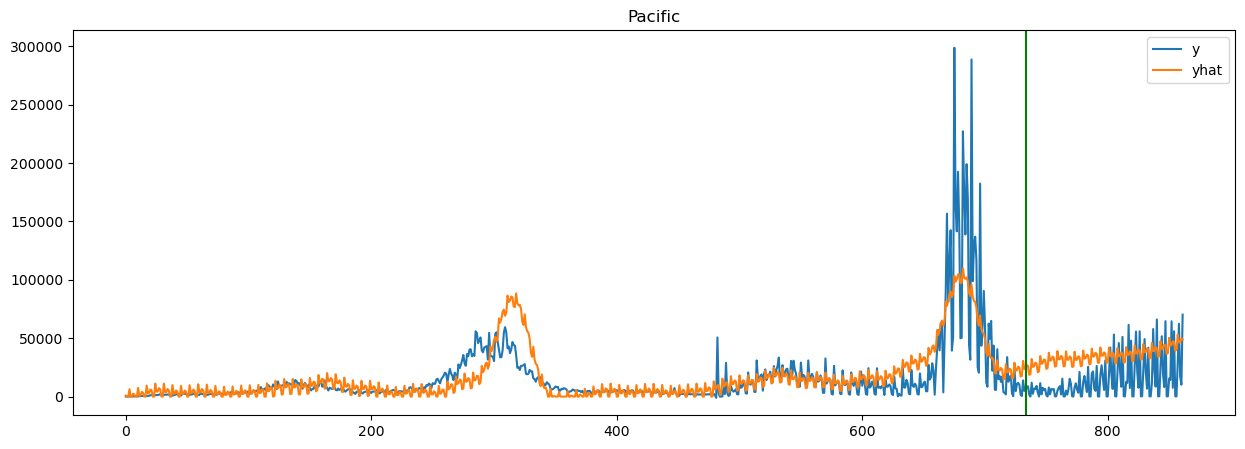

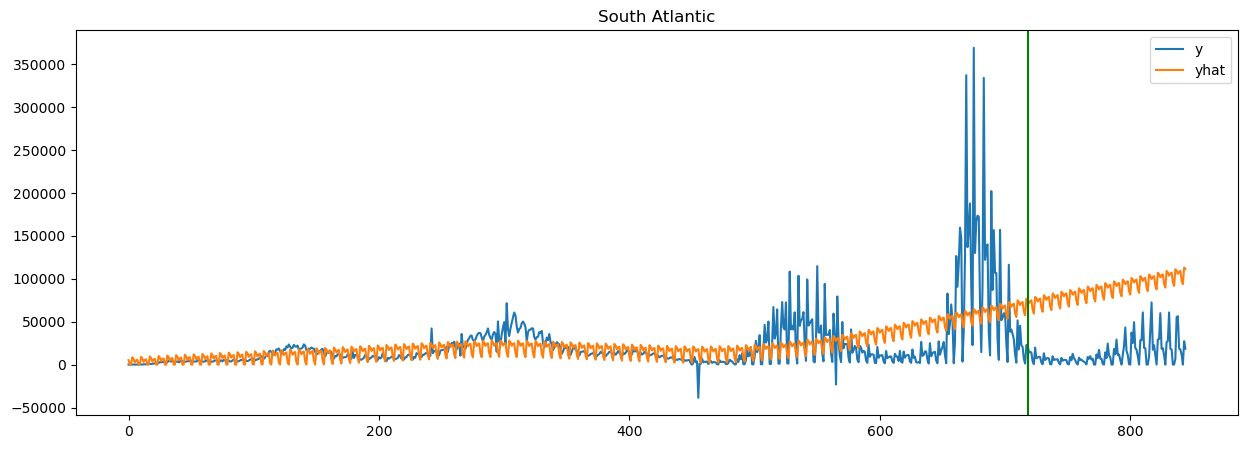

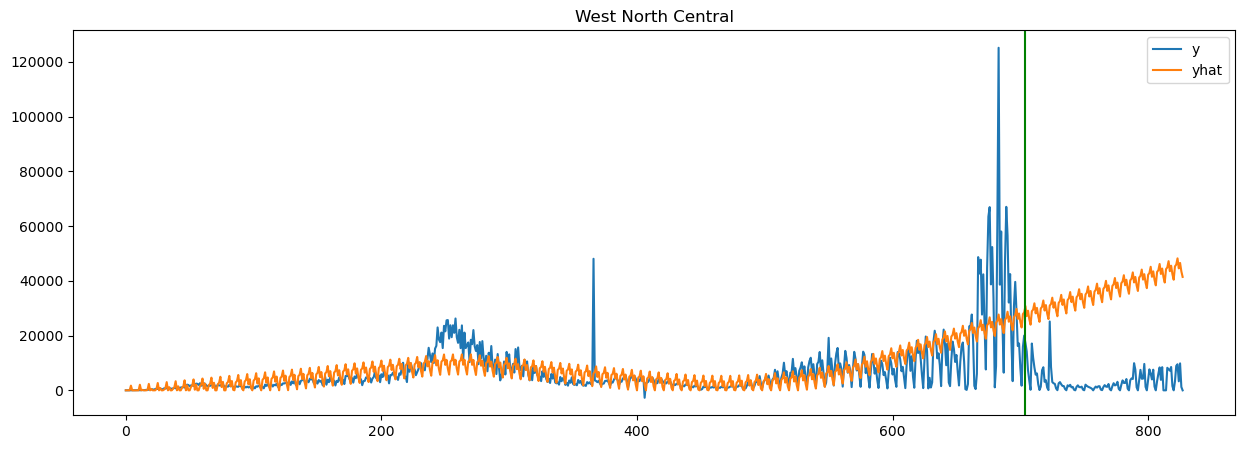

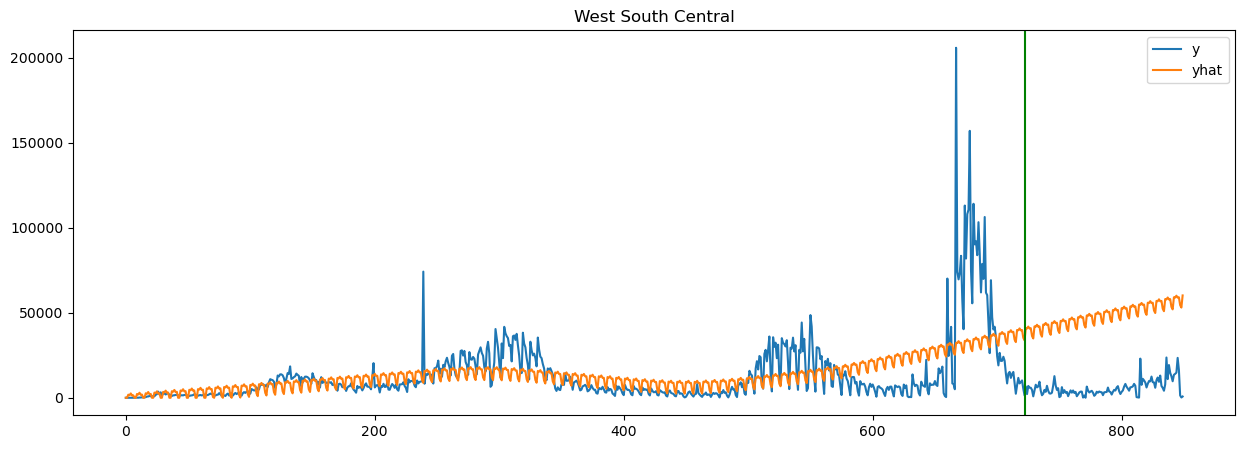

In [157]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import random
params_grid = {'changepoint_prior_scale':[0.05],
               'seasonality_prior_scale':[10]}
grid = ParameterGrid(params_grid)
best_params = []
best_mase = []
best_rmse = []
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
# for data1 in [enc]:
    data = process(data1)
    # data = data1.drop(columns = ['region']).dropna()
    data = data.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
    size = round(data.shape[0]*0.15)
    train = data.iloc[:-size]
    test = data.iloc[-size:]
    mases = []
    params = []
    rmses = []
    for p in grid:
        params.append(p)
        model = prophet.Prophet(changepoint_prior_scale=p['changepoint_prior_scale'],
                                seasonality_prior_scale=p['seasonality_prior_scale'])
        for col in train.drop(columns = 'ds').columns[(abs(train.drop(columns = 'ds').corr().y) > 0.5)].drop('y'):
            if col not in ['ds', 'y']:
                model.add_regressor(col)
        model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
        train_pred = model.predict(train)
        test_pred = model.predict(test)
        masetemp = mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y)
        mases.append(masetemp)
        rmsetemp = mean_squared_error(test.y, test_pred.yhat, squared = False)
        rmses.append(rmsetemp)
    best_mase.append(min(mases))
    best_params.append(params[np.argmin(mases)])
    best_rmse.append(min(rmses))
    model = prophet.Prophet(changepoint_prior_scale=params[np.argmin(mases)]['changepoint_prior_scale'],
                            seasonality_prior_scale=params[np.argmin(mases)]['seasonality_prior_scale']).fit(train)
    train_pred = model.predict(train)
    test_pred = model.predict(test)
    train_pred['yhat'] = train_pred['yhat'].apply(lambda x: max(0, x))
    test_pred['yhat'] = test_pred['yhat'].apply(lambda x: max(0, x))
    pd.concat([pd.concat([train.y,train_pred.yhat], axis=1),
               pd.concat([test.reset_index().y,test_pred.yhat], axis=1)],
               axis = 0).reset_index().drop(columns = 'index').plot(figsize=(15,5))
    plt.axvline(x = len(train), color = 'g')
    plt.legend()
    plt.title(data1.region.unique()[0])


16:38:11 - cmdstanpy - INFO - Chain [1] start processing
16:38:11 - cmdstanpy - INFO - Chain [1] done processing
16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:12 - cmdstanpy - INFO - Chain [1] done processing
16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:12 - cmdstanpy - INFO - Chain [1] done processing
16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:12 - cmdstanpy - INFO - Chain [1] done processing
16:38:12 - cmdstanpy - INFO - Chain [1] start processing
16:38:13 - cmdstanpy - INFO - Chain [1] done processing
16:38:13 - cmdstanpy - INFO - Chain [1] start processing
16:38:13 - cmdstanpy - INFO - Chain [1] done processing
16:38:13 - cmdstanpy - INFO - Chain [1] start processing
16:38:13 - cmdstanpy - INFO - Chain [1] done processing
16:38:13 - cmdstanpy - INFO - Chain [1] start processing
16:38:13 - cmdstanpy - INFO - Chain [1] done processing
16:38:13 - cmdstanpy - INFO - Chain [1] start processing
16:38:13 - cmdstanpy - INFO - Chain [1]

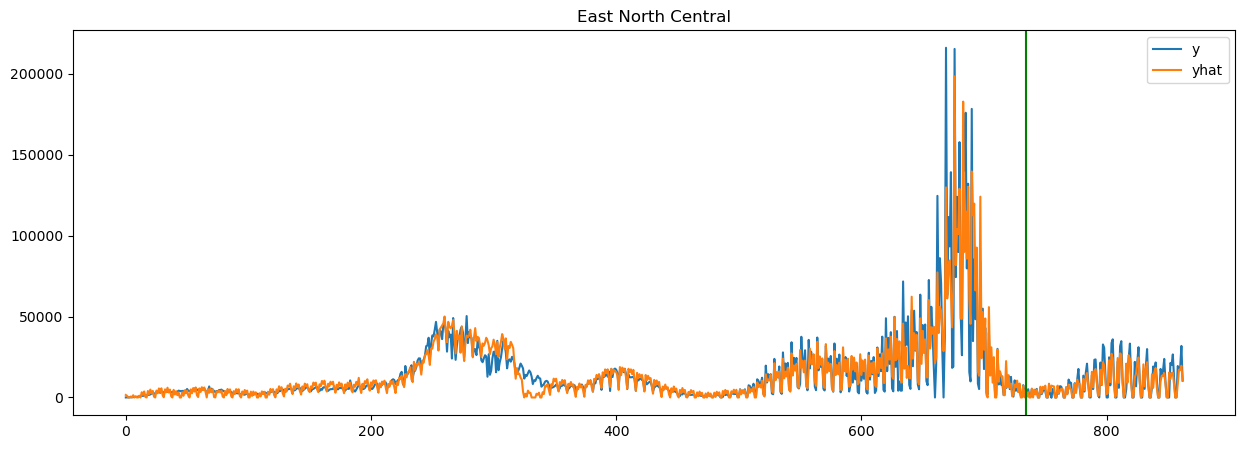

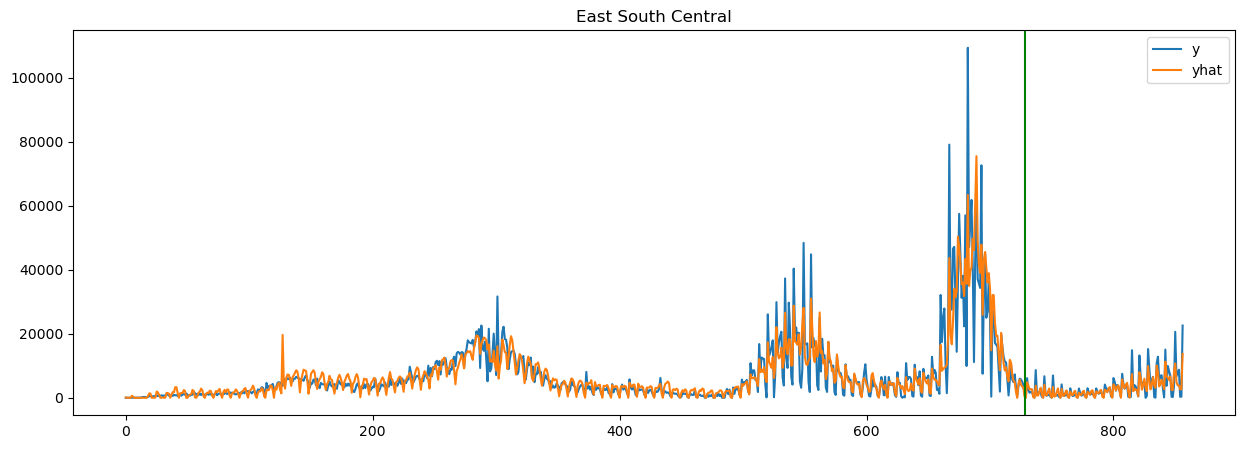

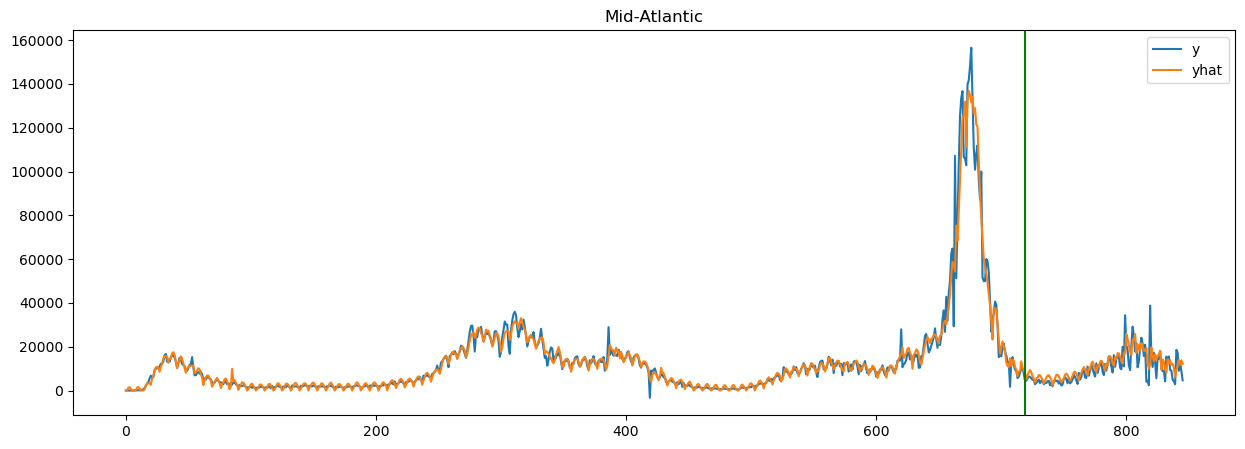

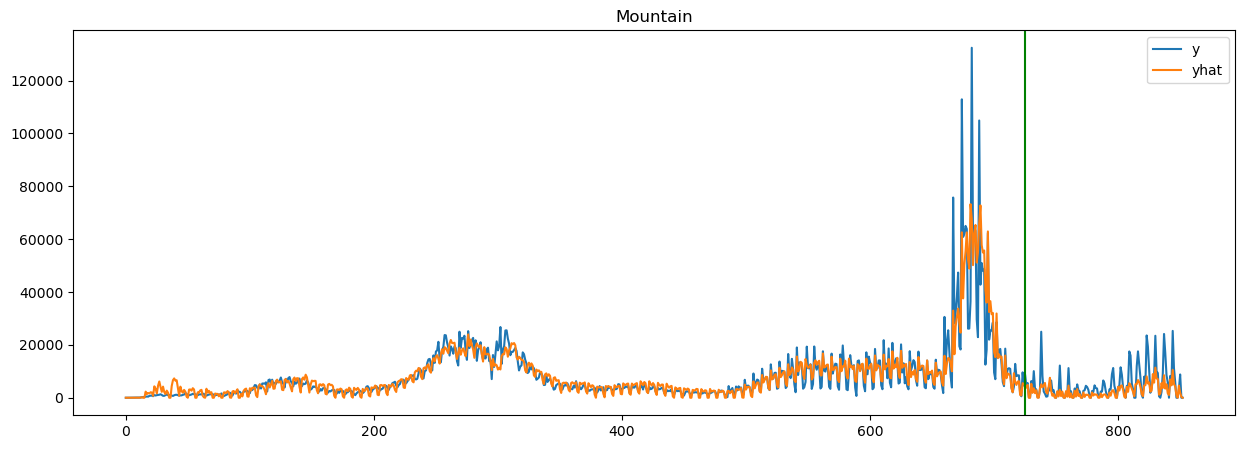

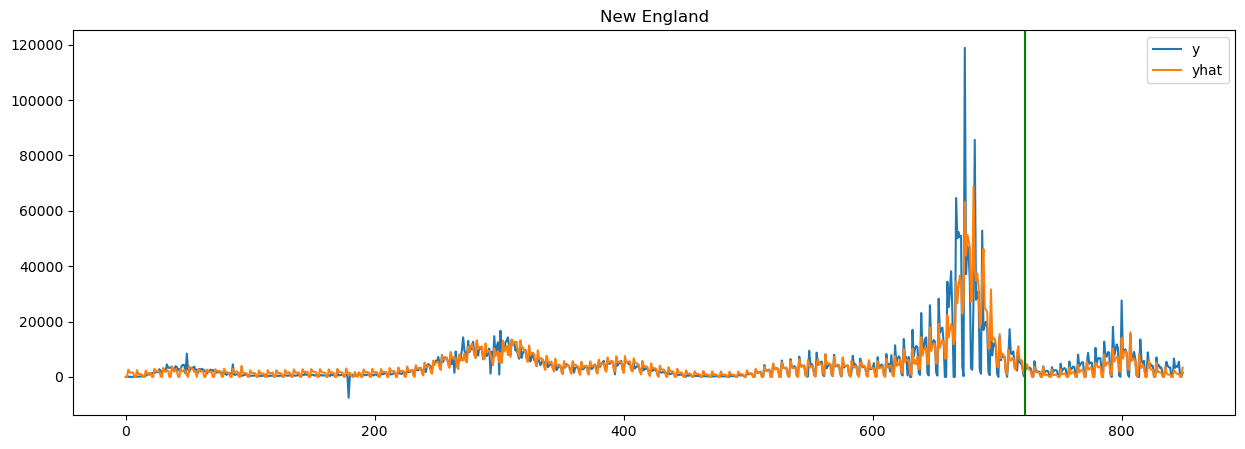

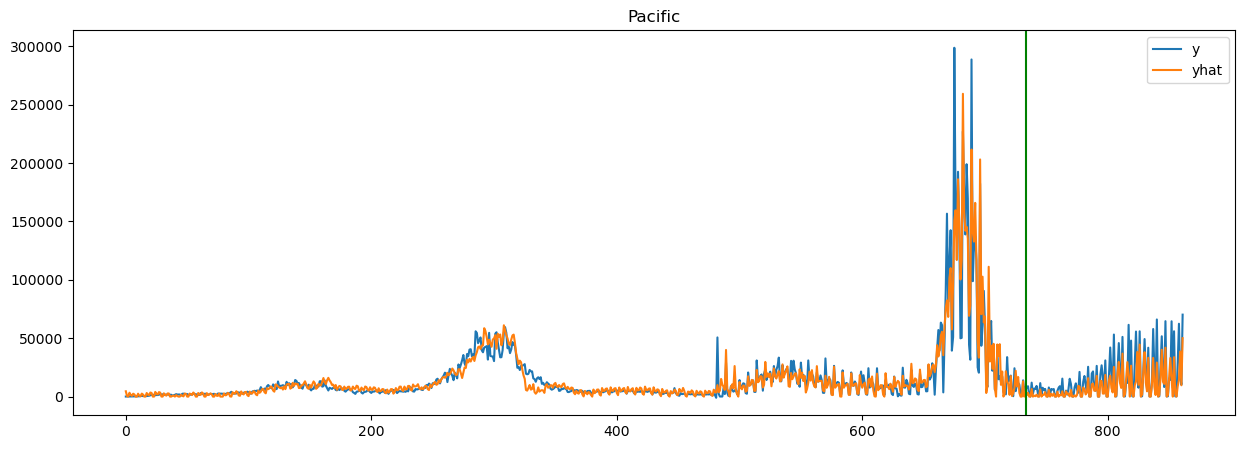

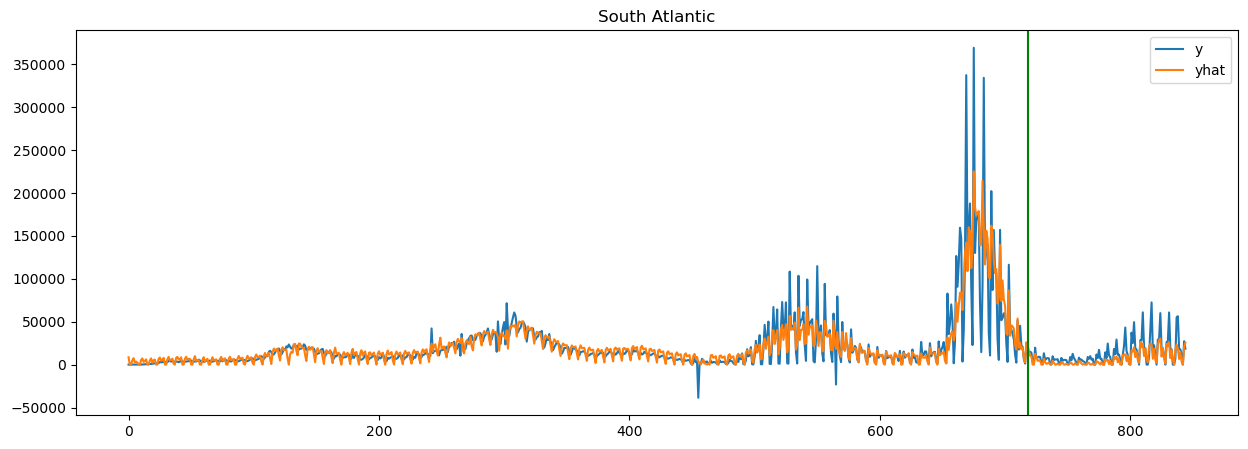

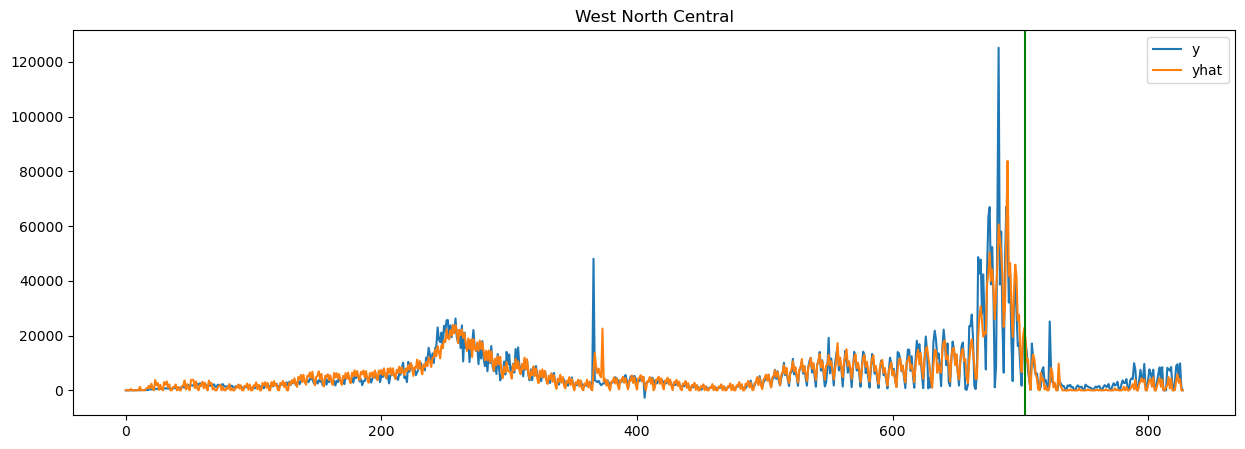

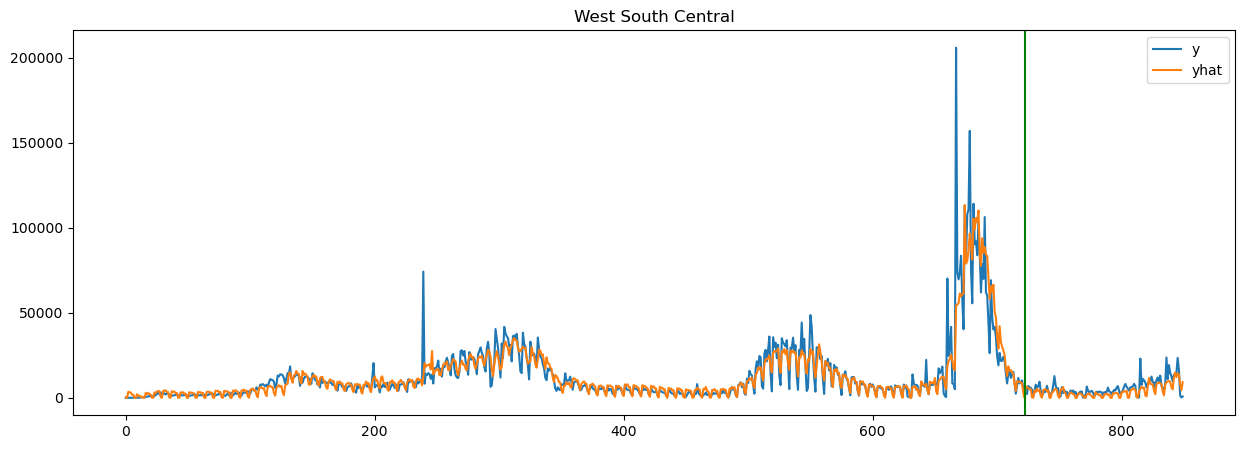

In [153]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import random
best_mase = []
best_rmse = []
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
# for data1 in [enc]:
    data = process(data1)
    # data = data1.drop(columns = ['region']).dropna()
    data = data.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'})
    size = round(data.shape[0]*0.15)
    train = data.iloc[:-size]
    test = data.iloc[-size:]
    model = prophet.Prophet()
    for col in train.drop(columns = 'ds').columns[(abs(train.drop(columns = 'ds').corr().y) > 0.5)].drop('y'):
        if col not in ['ds', 'y']:
            model.add_regressor(col)
    model=model.fit(train.reset_index().rename(columns={'date':'ds', 'new_confirmed':'y'}))
    train_pred = model.predict(train)
    test_pred = model.predict(test)
    masetemp = mean_absolute_scaled_error(test.y, test_pred.yhat, y_train = train.y)
    rmsetemp = mean_squared_error(test.y, test_pred.yhat, squared = False)
    best_mase.append(masetemp)
    best_rmse.append(rmsetemp)
    train_pred['yhat'] = train_pred['yhat'].apply(lambda x: max(0, x))
    test_pred['yhat'] = test_pred['yhat'].apply(lambda x: max(0, x))
    pd.concat([pd.concat([train.y,train_pred.yhat], axis=1),
               pd.concat([test.reset_index().y,test_pred.yhat], axis=1)],
               axis = 0).reset_index().drop(columns = 'index').plot(figsize=(15,5))
    plt.axvline(x = len(train), color = 'g')
    plt.legend()
    plt.title(data1.region.unique()[0])


In [155]:
best_rmse

[4831.79895992488,
 2271.9012542848623,
 4986.6056953112575,
 4931.497880200781,
 2808.312649756206,
 12840.231324713624,
 11750.916122073742,
 3839.2871481664506,
 4017.5847505960965]

In [136]:
 pd.concat([pd.concat([train.y,train_pred.yhat], axis=1),
               pd.concat([test.reset_index().y,test_pred.yhat], axis=1)],
               axis = 0).reset_index().drop(columns = 'index')

,y,yhat
0,27.0,0.000000
1,41.0,1500.625230
2,49.0,0.000000
3,64.0,0.000000
4,125.0,6258.278892
...,...,...
858,19441.0,24953.505909
859,17643.0,15780.876698
860,18425.0,21114.042495
861,31850.0,17436.592369


In [138]:
test_pred.yhat

0      17336.673524
1      13588.759645
2      17194.479082
3       7472.649934
4       5192.764674
           ...     
124    24953.505909
125    15780.876698
126    21114.042495
127    17436.592369
128    21066.812637
Name: yhat, Length: 129, dtype: float64